In [2]:
import os
os.chdir('../../')
os.getcwd()

'/Users/henriquecosta/workspace/studies/modern-ml'

In [3]:
import pandas as pd
import numpy as np
import catboost as cb
from sklearn.metrics import log_loss, average_precision_score
from sklearn.model_selection import train_test_split
from venn_abers import VennAbersCalibrator
from matplotlib import pyplot as plt
import seaborn as sns
import mlflow
import shap

/Users/henriquecosta/workspace/studies/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mlflow.set_experiment('final_model')

<Experiment: artifact_location='file:///Users/henriquecosta/workspace/studies/modern-ml/mlruns/614710356249417379', creation_time=1738538096390, experiment_id='614710356249417379', last_update_time=1738538096390, lifecycle_stage='active', name='final_model', tags={}>

In [5]:
df_train = pd.read_parquet('./case/data/processed/lending_club_case_train_dataset_v2.parquet')
df_valid = pd.read_parquet('./case/data/processed/lending_club_case_valid_dataset_v2.parquet')
df_test  = pd.read_parquet('./case/data/processed/lending_club_case_test_dataset_v2.parquet')

In [24]:
FEATURES = ['funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'revol_bal',
 'revol_util',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_bc_tl',
 'num_il_tl',
 'num_rev_tl_bal_gt_0',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'issue_d_elapse',
 'earliest_cr_line_since',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'verification_status_joint',
 'issue_d_month',
 'issue_d_day',
 'issue_d_dayofweek',
 'issue_d_dayofyear',
 'issue_d_quarter',
 'earliest_cr_line_month',
 'earliest_cr_line_day',
 'earliest_cr_line_dayofweek',
 'earliest_cr_line_dayofyear',
 'earliest_cr_line_quarter',
 'sec_app_earliest_cr_line_month',
 'sec_app_earliest_cr_line_day',
 'sec_app_earliest_cr_line_dayofweek',
 'sec_app_earliest_cr_line_dayofyear',
 'sec_app_earliest_cr_line_quarter'
]

TEXT_FEATURES = ['title']   
CATEGORICAL_FEATURES = [
    c for c in df_train.select_dtypes(include='category').columns if c in set(FEATURES) - set(TEXT_FEATURES)
]

In [26]:
df_test['title'] = df_test['title'].astype(str)
df_train['title'] = df_train['title'].astype(str)
df_valid['title'] = df_valid['title'].astype(str)

In [27]:
X_train = df_train[FEATURES]
y_train = df_train['default']

X_valid = df_valid[FEATURES]
y_valid = df_valid['default']

X_test = df_test[FEATURES]

In [28]:
X_valid, X_calibration, y_valid, y_calibration = train_test_split(X_valid, y_valid, test_size=.2, random_state=42)

In [29]:
train_pool  = cb.Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES, text_features=['title'])
valid_pool = cb.Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES, text_features=['title'])

In [30]:
with mlflow.start_run(run_name='calibrated_model'):
    params = dict(
        iterations=5000,
        learning_rate=0.06579757078681805,
        subsample=0.8,
        colsample_bylevel=0.2,
        depth=5,
        l2_leaf_reg=1,
        auto_class_weights='SqrtBalanced',
        eval_metric='Logloss',
        verbose=10,
    )

    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100)
    y_pred = model.predict_proba(X_valid)[:, 1]
    mlflow.log_params(params)
    mlflow.log_metric('log_loss_non_calibrated', log_loss(y_valid, y_pred))
    mlflow.log_metric('avg_pr_non_calibrated', average_precision_score(y_valid, y_pred))

    p_cal = model.predict_proba(X_calibration)
    p_val = model.predict_proba(X_valid)
    va = VennAbersCalibrator()
    va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_val)
    y_pred_va = va_prefit_prob[:, 1]
    mlflow.log_metric('log_loss', log_loss(y_valid, y_pred_va))
    mlflow.log_metric('avg_pr', average_precision_score(y_valid, y_pred_va))

0:	learn: 0.6765412	test: 0.6798853	best: 0.6798853 (0)	total: 2.18s	remaining: 3h 1m 57s
10:	learn: 0.5985037	test: 0.6257997	best: 0.6257997 (10)	total: 14.9s	remaining: 1h 52m 45s
20:	learn: 0.5780340	test: 0.6172811	best: 0.6172811 (20)	total: 28s	remaining: 1h 50m 43s
30:	learn: 0.5706046	test: 0.6153886	best: 0.6153886 (30)	total: 39.1s	remaining: 1h 44m 27s
40:	learn: 0.5675107	test: 0.6147325	best: 0.6147325 (40)	total: 50.5s	remaining: 1h 41m 51s
50:	learn: 0.5654545	test: 0.6134912	best: 0.6134912 (50)	total: 1m 1s	remaining: 1h 39m 31s
60:	learn: 0.5639992	test: 0.6123431	best: 0.6123431 (60)	total: 1m 12s	remaining: 1h 37m 45s
70:	learn: 0.5630688	test: 0.6116591	best: 0.6116591 (70)	total: 1m 24s	remaining: 1h 37m 16s
80:	learn: 0.5622927	test: 0.6106180	best: 0.6106180 (80)	total: 1m 33s	remaining: 1h 34m 22s
90:	learn: 0.5616186	test: 0.6098377	best: 0.6098377 (90)	total: 1m 43s	remaining: 1h 33m 24s
100:	learn: 0.5611119	test: 0.6092030	best: 0.6092030 (100)	total: 1m 5

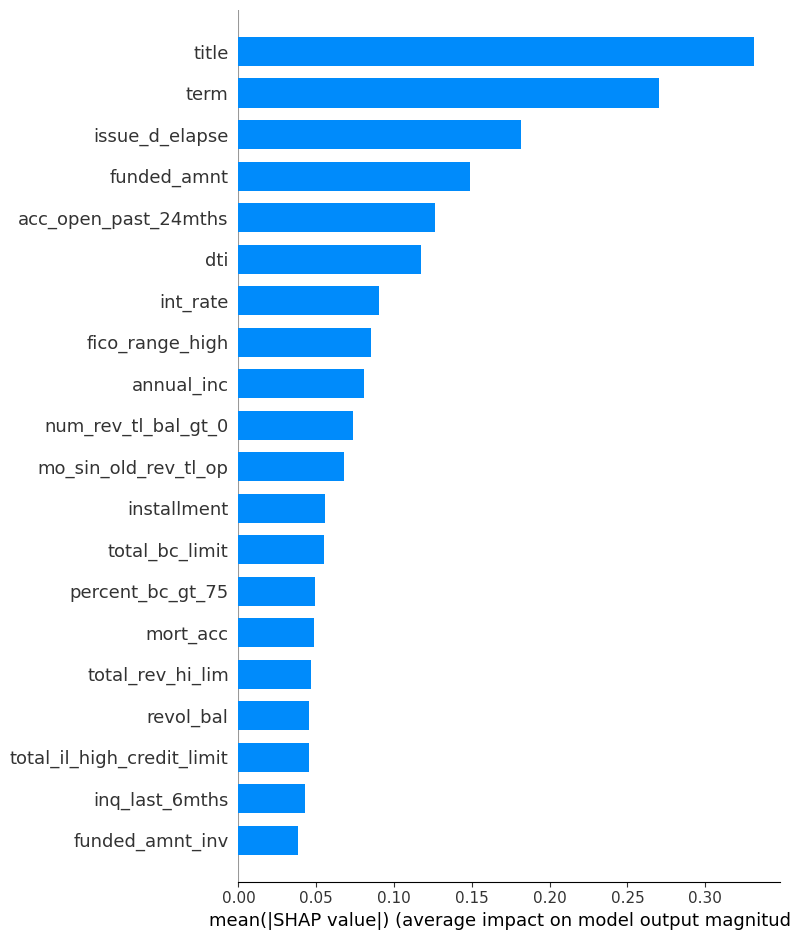

In [31]:
# Get SHAP values (returns (n_samples, n_features + 1) array)
shap_values = model.get_feature_importance(valid_pool, type='ShapValues')

# Remove the last column (expected value)
shap_values = shap_values[:, :-1]

# Plot feature importance using SHAP values
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

In [32]:
p_test = model.predict_proba(X_test)
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_test)
y_submit_va = va_prefit_prob[:, 1]

In [33]:
submission = df_test[['id']].copy()
submission['probabilities'] = y_submit_va

submission.to_csv('./case/data/submission/henrique_schumann.csv', index=False)

In [34]:
test_file = pd.read_parquet('./case/data/processed/test_dataset_with_target.parquet')[['id', 'default']]
test_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538826 entries, 472065 to 1082981
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       538826 non-null  Int64  
 1   default  208329 non-null  float16
dtypes: Int64(1), float16(1)
memory usage: 9.8 MB


In [35]:
test_file = test_file.merge(submission, on='id', how='inner')
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538826 entries, 0 to 538825
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             538826 non-null  Int64  
 1   default        208329 non-null  float16
 2   probabilities  538826 non-null  float64
dtypes: Int64(1), float16(1), float64(1)
memory usage: 9.8 MB


In [37]:
test_file = test_file.dropna()

y_true = test_file['default']
y_pred = test_file['probabilities']

print('Final Logloss:', log_loss(y_true, y_pred))

Final Logloss: 0.4869198970822572


In [18]:
test_file['default'] = test_file['default'].astype(int)

<Axes: xlabel='default'>

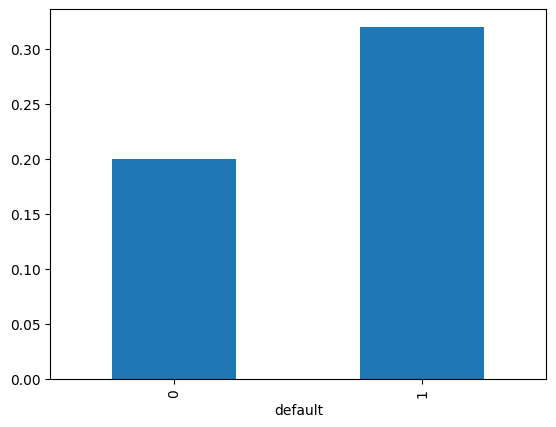

In [19]:
test_file.groupby('default')['probabilities'].mean().plot.bar()

In [20]:
test_file['default'].isnull().mean()

0.0

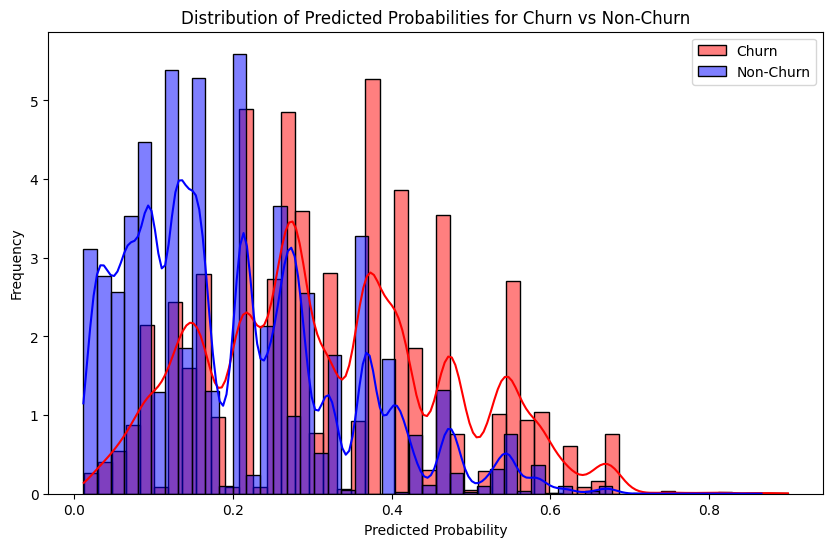

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(test_file.loc[test_file['default'] == 1, 'probabilities'], bins=50, color='red', label='Churn', kde=True, stat='density')
sns.histplot(test_file.loc[test_file['default'] == 0, 'probabilities'], bins=50, color='blue', label='Non-Churn', kde=True, stat='density')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for Churn vs Non-Churn')
plt.legend()